In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
# import theano
import scipy.ndimage
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, merge, Convolution3D,Conv3D, MaxPooling3D, UpSampling2D,BatchNormalization,Activation,Dense,Dropout,Flatten
from keras.optimizers import Adam,SGD
from keras import backend as K
K.set_image_dim_ordering('th') 
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential, Model
from sklearn.model_selection import KFold

/home/usma/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
keras.callbacks.TensorBoard(log_dir='/home/usma/Documents/Graph_Research', histogram_freq=0,  
          write_graph=True, write_images=True)

## Add labels

In [20]:
dataDirectory = '../unlabelled_segment/'
lungPatients = os.listdir(dataDirectory)
labels = pd.read_csv('/home/usma/Downloads/stage1_solution.csv', index_col=0)
size = 50
NoSlices = 40

In [21]:
def dataProcessing(patient, labels_df, size, noslices=40, visualize=False):
    
    label = labels_df.at[patient[:-4], 'cancer']
    path = dataDirectory + patient
    slices = np.load(path)
#     print(slices.shape)
#     slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(each_slice, (size, size)) for each_slice in slices]
#     print(len(slices))

    if label == 1:
        label = np.array([0, 1])
    elif label == 0:
        label = np.array([1, 0])
    return np.array(slices),label



In [ ]:
count=0
imageData = []
for num, patient in enumerate(lungPatients):
    if num % 10 == 0:
        print('Saved -', num)
    try:
        img_data, label = dataProcessing(patient, labels, size=size, noslices=NoSlices)
        imageData.append([img_data, label,patient])
    except KeyError as e:
        print('Data is unlabeled')
        count=count+1
print(count)

## Load files

In [2]:
file1 = np.load("/media/usma/New Volume/usma_10_05_2018/abhishek/Kaggle_lung_segmentation.npy")
# file2 = np.load("/home/usma/Desktop/Research_Project/practical/Myproject/DataFiles/imageDataNew-50-50-20.npy")
file3 =  np.load("/media/usma/New Volume/usma_10_05_2018/abhishek/segmented_unlabelled_data_with_labels.npy")

In [3]:
print(file1.shape)
# print(file2.shape)
print(file3.shape)

(1759, 3)
(198, 3)


## Resample and normalize data

In [4]:
img_rows=50
img_cols=50
depth=40
num_classes=2

In [5]:
def resample(f):
    resample_array=np.zeros((depth,img_rows,img_cols))
    for i in range(len(f)):
        resample_array[i,:,:]=f[i]
    return resample_array

In [6]:
newdata1=np.zeros((len(file1),depth,img_rows,img_cols))
newlabel1=np.zeros((len(file1),2))
for i in range(len(file1)):
    newdata1[i,:,:,:]=resample(file1[i][0])
    newlabel1[i,:]=(file1[i][1])

In [7]:
print("patient_images_array shape: ", file1.shape)
print("newdata shape:", newdata1.shape)

patient_images_array shape:  (1759, 3)
newdata shape: (1759, 40, 50, 50)


In [8]:
# newdata2=np.zeros((len(file2),depth,img_rows,img_cols))
# newlabel2=np.zeros((len(file2),2))
# for i in range(len(file2)):
#     newdata2[i,:,:,:]=resample(file2[i][0])
#     newlabel2[i,:]=(file2[i][1])

In [8]:
newdata3=np.zeros((len(file3),depth,img_rows,img_cols))
newlabel3=np.zeros((len(file3),2))
for i in range(len(file3)):
    newdata3[i,:,:,:]=resample(file3[i][0])
    newlabel3[i,:]=(file3[i][1])

In [9]:
print("Kaggle_segmented_data: ",newdata1.shape)
print("Kaggle_segmented_label: ",newlabel1.shape)

# print("Kaggle_NSC_segmented_data: ",newdata2.shape)
# print("Kaggle_NSC_segmented_label: ",newlabel2.shape)

print("Unlabelled_data: ",newdata3.shape)
print("unlabelled_segmented_label: ",newlabel3.shape)

Kaggle_segmented_data:  (1759, 40, 50, 50)
Kaggle_segmented_label:  (1759, 2)
Unlabelled_data:  (198, 40, 50, 50)
unlabelled_segmented_label:  (198, 2)


In [12]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
image = (newdata1 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
image[image>1] = 1.
image[image<0] = 0.
image = image - PIXEL_MEAN
data1=image[:,np.newaxis,:,:];
print(data1.shape)

(1759, 1, 40, 50, 50)


In [13]:
print(data1.min())
print(data1.max())

-0.25
0.75


In [39]:
# MIN_BOUND = -1000.0
# MAX_BOUND = 400.0
# PIXEL_MEAN = 0.25
# image = (newdata2 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
# image[image>1] = 1.
# image[image<0] = 0.
# image = image - PIXEL_MEAN
# data2=image[:,np.newaxis,:,:];
# print(data2.shape)

In [14]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
image = (newdata3 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
image[image>1] = 1.
image[image<0] = 0.
image = image - PIXEL_MEAN
data3=image[:,np.newaxis,:,:];
print(data3.shape)

(198, 1, 40, 50, 50)


In [10]:
data1=newdata1[:,np.newaxis,:,:];######### Test data
# data2=newdata2[:,np.newaxis,:,:];
data3=newdata3[:,np.newaxis,:,:];
print("Input shape: ",data1.shape)
# print(data2.shape)
print(data3.shape)

Input shape:  (1759, 1, 40, 50, 50)
(198, 1, 40, 50, 50)


In [17]:
del data3

In [12]:
import gc
del newdata1
# del newlabel3
del file1
del newdata3
del file3
# del newdata1
# del file1
gc.collect()


0

In [11]:
X_train = data1
Y_train=newlabel1
X_test = data3
Y_test = newlabel3

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
        data1, newlabel1, test_size=0.2, random_state=43)

In [30]:
import gc
del data1
# del newlabel1
del data3
# del newlabel3
gc.collect()

756

In [74]:
print(X_train[:-1].shape)

(1758, 1, 40, 50, 50)


In [14]:
# X_T=data3
# Y_T=newlabel3    ####### with normalisation


X_H = data3       ########## without normalization
Y_H = newlabel3

In [15]:
print(X_H.shape)

(198, 1, 40, 50, 50)


In [16]:
print(Y_H.shape)

(198, 2)


In [12]:
j='a'

In [14]:
j=j+str(1)

In [15]:
j

'a1'

In [12]:
def plot(i):
    plt.figure(figsize=(13,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['Training loss', 'Test loss'], loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(history.history['acc'], marker='.', color='g')
    plt.plot(history.history['val_acc'], marker='.',color='y')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['Training acc', 'Test acc'], loc='lower right')
    plt.savefig("graph"+str(i))

In [13]:
model = Sequential()

model.add(Conv3D(filters=32, 
                        kernel_size=(3, 3, 3), 
                        activation='relu', 
                        input_shape=(1,depth, img_rows,img_cols),
                        padding='same'
                        ))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 

model.add(Conv3D(filters=64, 
                        kernel_size=(3, 3, 3), 
                        activation='relu', 
                        input_shape=(1,depth, img_rows,img_cols),
                        padding='same'
                        ))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 

model.add(Conv3D(filters=128, 
                        kernel_size=(3, 3, 3), 
                        activation='relu', 
                        input_shape=(1,depth, img_rows,img_cols),
                        padding='same'
                        ))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 

# model.add(BatchNormalization(axis=1))

model.add(Conv3D(filters=256, 
                        kernel_size=(3, 3, 3), 
                        activation='relu', 
                        input_shape=(1,depth, img_rows,img_cols),
                        padding='same'
                        ))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same')) 
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 

model.add(Conv3D(filters=512, 
                        kernel_size=(3, 3, 3), 
                        activation='relu', 
                        input_shape=(1,depth, img_rows,img_cols),
                        padding='same'
                        ))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same')) 
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 



model.add(Conv3D(filters=1024, 
                        kernel_size=(3, 3, 3), 
                        activation='relu', 
                        input_shape=(1,depth, img_rows,img_cols),
                        padding='same'
                        ))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same')) 
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 



model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

optim = Adam(lr=1e-3)
model.compile(optimizer=optim, loss='binary_crossentropy',metrics=['accuracy'])

model.summary()
# model.add(UpSampling2D(size=(2,2)))
# model.add(Dense(128, activation='relu'))
# model.add(Conv3D(filters=1, 
#                         kernel_size=(3, 3, 3), 
#                         activation='sigmoid', 
#                         input_shape=(1,depth, img_rows,img_cols),
#                         padding='same'
#                         ))
# model.add(UpSampling2D(size=(2,2)))
# model.add(UpSampling2D(size=(2,2)))
# model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=[dice_coef])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 40, 50, 50)    896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 20, 25, 25)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 20, 25, 25)    128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 20, 25, 25)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 20, 25, 25)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 64, 10, 13, 13)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 10, 13, 13)    256       
__________

In [33]:
from keras.utils import plot_model
plot_model(model, to_file='/home/usma/Desktop/Research_Project/Thesis-Latex-Template-master (2)/images/model_new.png')

Train on 1319 samples, validate on 440 samples
Epoch 1/20
1319/1319 [==============================] - 54s 41ms/step - loss: 0.6997 - acc: 0.6016 - val_loss: 0.6910 - val_acc: 0.5682
Epoch 2/20
1319/1319 [==============================] - 54s 41ms/step - loss: 0.6658 - acc: 0.6353 - val_loss: 0.6388 - val_acc: 0.6500
Epoch 3/20
1319/1319 [==============================] - 54s 41ms/step - loss: 0.6601 - acc: 0.6152 - val_loss: 0.6493 - val_acc: 0.6159
Epoch 4/20
1319/1319 [==============================] - 54s 41ms/step - loss: 0.6384 - acc: 0.6399 - val_loss: 0.7914 - val_acc: 0.5295
Epoch 5/20
1319/1319 [==============================] - 54s 41ms/step - loss: 0.6251 - acc: 0.6505 - val_loss: 0.6736 - val_acc: 0.5966
Epoch 6/20
1319/1319 [==============================] - 54s 41ms/step - loss: 0.6761 - acc: 0.5705 - val_loss: 0.7366 - val_acc: 0.6023
Epoch 7/20
1319/1319 [==============================] - 54s 41ms/step - loss: 0.6912 - acc: 0.5732 - val_loss: 0.7718 - val_acc: 0.6045
E

Epoch 20/20
1319/1319 [==============================] - 55s 42ms/step - loss: 0.1361 - acc: 0.9280 - val_loss: 1.1256 - val_acc: 0.7080
Train on 1320 samples, validate on 439 samples
Epoch 1/20
1320/1320 [==============================] - 58s 44ms/step - loss: 0.3422 - acc: 0.8473 - val_loss: 0.2300 - val_acc: 0.8941
Epoch 2/20
1320/1320 [==============================] - 54s 41ms/step - loss: 0.2036 - acc: 0.9011 - val_loss: 0.4160 - val_acc: 0.8166
Epoch 3/20
1320/1320 [==============================] - 55s 42ms/step - loss: 0.1512 - acc: 0.9220 - val_loss: 0.1724 - val_acc: 0.9271
Epoch 4/20
1320/1320 [==============================] - 55s 42ms/step - loss: 0.1619 - acc: 0.9159 - val_loss: 0.2324 - val_acc: 0.8872
Epoch 5/20
1320/1320 [==============================] - 54s 41ms/step - loss: 0.1285 - acc: 0.9322 - val_loss: 0.1472 - val_acc: 0.9089
Epoch 6/20
1320/1320 [==============================] - 54s 41ms/step - loss: 0.1458 - acc: 0.9193 - val_loss: 0.3114 - val_acc: 0.8713


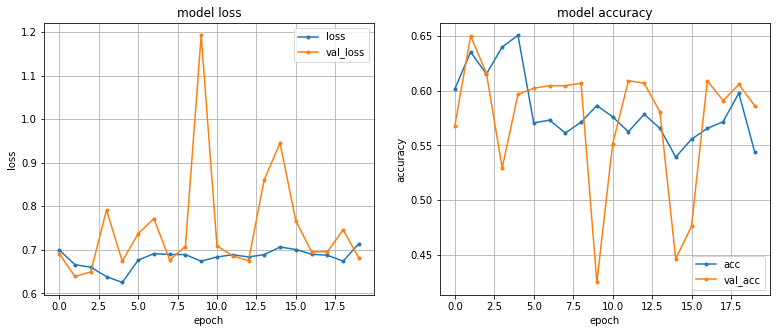

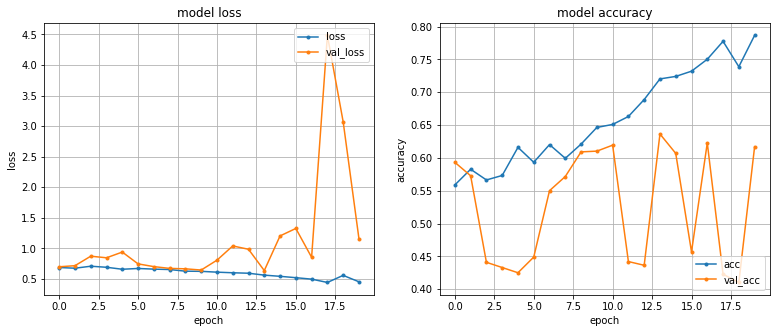

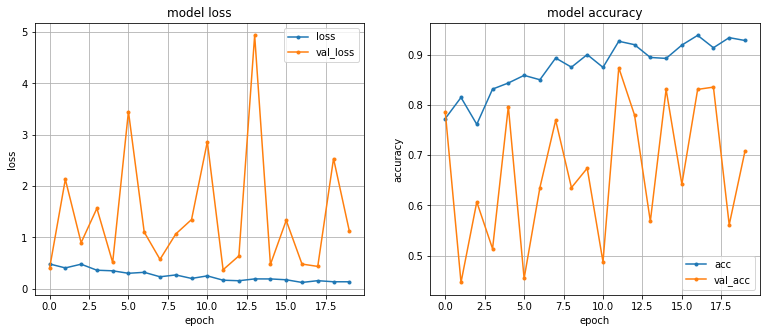

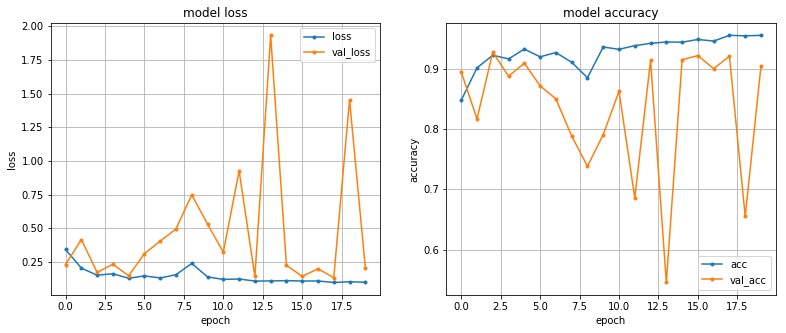

In [16]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4,shuffle=True)
kf.get_n_splits(X)
val_l = []
val_a = []
i=0
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    i=i+1;
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
#     tbCallBack = keras.callbacks.TensorBoard(log_dir='/home/usma/Documents/Graph', histogram_freq=0, write_graph=True, write_images=True)
    history=model.fit(X_train, Y_train,epochs=20,batch_size=32,validation_data=(X_test, Y_test))
#     history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(i)
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
   
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

# Model 1

In [27]:
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(1,depth, img_rows,img_cols)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
                       
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

# model.add(Conv3D(128, kernel_size=(3, 3, 3),  activation='relu', padding='same'))

model.add(Conv3D(128, kernel_size=(3, 3, 3),  activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))


# model.add(Conv3D(512, kernel_size=(3, 3, 3),  activation='relu', padding='same'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same'))
# model.add(BatchNormalization(axis=1))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

optim = Adam(lr=1e-3)
model.compile(optimizer=optim, loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 32, 40, 50, 50)    896       
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 32, 20, 25, 25)    0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 32, 20, 25, 25)    128       
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 20, 25, 25)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 64, 20, 25, 25)    55360     
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 64, 10, 13, 13)    0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 64, 10, 13, 13)    256       
__________

In [20]:
del model

In [14]:
model.layers[0].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'batch_input_shape': (None, 1, 40, 50, 50),
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'data_format': 'channels_first',
 'dilation_rate': (1, 1, 1),
 'dtype': 'float32',
 'filters': 32,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'kernel_size': (3, 3, 3),
 'name': 'conv3d_1',
 'padding': 'same',
 'strides': (1, 1, 1),
 'trainable': True,
 'use_bias': True}

In [16]:
model.count_params()

2285954

## ONLY KAGGLE WHOLE DATA FOR TRAINING

In [20]:
history=model.fit(X_train, Y_train,epochs=50,validation_data=(X_test, Y_test),batch_size=32)

Train on 1759 samples, validate on 198 samples
Epoch 1/50
1759/1759 [==============================] - 19s 11ms/step - loss: 0.8969 - acc: 0.5114 - val_loss: 0.9687 - val_acc: 0.3182
Epoch 2/50
1759/1759 [==============================] - 18s 10ms/step - loss: 0.7699 - acc: 0.5460 - val_loss: 1.1565 - val_acc: 0.3056
Epoch 3/50
1759/1759 [==============================] - 18s 10ms/step - loss: 0.7600 - acc: 0.5381 - val_loss: 0.8338 - val_acc: 0.3131
Epoch 4/50
1759/1759 [==============================] - 18s 10ms/step - loss: 0.7257 - acc: 0.5694 - val_loss: 0.6821 - val_acc: 0.5278
Epoch 5/50
1759/1759 [==============================] - 18s 10ms/step - loss: 0.7293 - acc: 0.5560 - val_loss: 0.8093 - val_acc: 0.3283
Epoch 6/50
1759/1759 [==============================] - 18s 10ms/step - loss: 0.7226 - acc: 0.5637 - val_loss: 0.9213 - val_acc: 0.3232
Epoch 7/50
1759/1759 [==============================] - 18s 10ms/step - loss: 0.7092 - acc: 0.5779 - val_loss: 0.6823 - val_acc: 0.5657
E

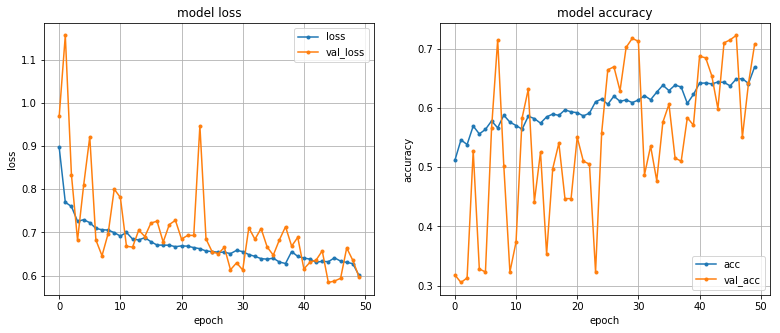

In [21]:
plot()

## Rough

In [20]:
from keras.callbacks import TensorBoard
import tensorflow as tf
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='/home/usma/Documents/Graph_Research', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [19]:
del model

In [16]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='/home/usma/Documents/Graph_Research', histogram_freq=0, write_graph=True, write_images=True)
history=model.fit(X_train, Y_train,epochs=50,batch_size=32,validation_data=(X_test, Y_test),callbacks=[TrainValTensorBoard(write_graph=True)])

Train on 1407 samples, validate on 352 samples
Epoch 1/50
1407/1407 [==============================] - 26s 19ms/step - loss: 0.9667 - acc: 0.4936 - val_loss: 0.7124 - val_acc: 0.5639
Epoch 2/50
1407/1407 [==============================] - 24s 17ms/step - loss: 0.8617 - acc: 0.5423 - val_loss: 0.7629 - val_acc: 0.4119
Epoch 3/50
1407/1407 [==============================] - 24s 17ms/step - loss: 0.8313 - acc: 0.5405 - val_loss: 0.8168 - val_acc: 0.4162
Epoch 4/50
1407/1407 [==============================] - 24s 17ms/step - loss: 0.7875 - acc: 0.5398 - val_loss: 0.6861 - val_acc: 0.5554
Epoch 5/50
1407/1407 [==============================] - 24s 17ms/step - loss: 0.7907 - acc: 0.5515 - val_loss: 0.7762 - val_acc: 0.4318
Epoch 6/50
1407/1407 [==============================] - 23s 17ms/step - loss: 0.7597 - acc: 0.5490 - val_loss: 0.7479 - val_acc: 0.4517
Epoch 7/50
1407/1407 [==============================] - 23s 17ms/step - loss: 0.7582 - acc: 0.5615 - val_loss: 0.7519 - val_acc: 0.4332
E

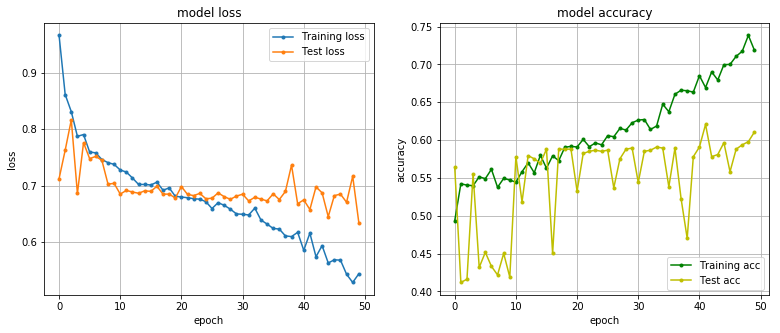

In [17]:
plot()

Train on 1319 samples, validate on 440 samples
Epoch 1/50
1319/1319 [==============================] - 25s 19ms/step - loss: 1.1499 - acc: 0.5208 - val_loss: 0.7147 - val_acc: 0.5523
Epoch 2/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.9510 - acc: 0.5193 - val_loss: 1.2002 - val_acc: 0.4250
Epoch 3/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.9301 - acc: 0.5140 - val_loss: 0.6798 - val_acc: 0.5818
Epoch 4/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.8706 - acc: 0.5307 - val_loss: 0.7405 - val_acc: 0.5886
Epoch 5/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.8432 - acc: 0.5481 - val_loss: 0.8000 - val_acc: 0.5955
Epoch 6/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.8491 - acc: 0.5330 - val_loss: 0.8206 - val_acc: 0.4250
Epoch 7/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.7646 - acc: 0.5565 - val_loss: 0.6775 - val_acc: 0.5773
E

1319/1319 [==============================] - 22s 17ms/step - loss: 0.5880 - acc: 0.6846 - val_loss: 0.5817 - val_acc: 0.6727
Epoch 11/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.5702 - acc: 0.7104 - val_loss: 0.5786 - val_acc: 0.6682
Epoch 12/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.5815 - acc: 0.6922 - val_loss: 0.5904 - val_acc: 0.6795
Epoch 13/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.5585 - acc: 0.7187 - val_loss: 0.6328 - val_acc: 0.5955
Epoch 14/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.5211 - acc: 0.7415 - val_loss: 0.8166 - val_acc: 0.6273
Epoch 15/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.5262 - acc: 0.7271 - val_loss: 0.5881 - val_acc: 0.6682
Epoch 16/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.5333 - acc: 0.7218 - val_loss: 0.7084 - val_acc: 0.5955
Epoch 17/50
1319/1319 [==============================

1319/1319 [==============================] - 22s 17ms/step - loss: 0.2393 - acc: 0.8954 - val_loss: 0.1833 - val_acc: 0.9273
Epoch 20/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.2118 - acc: 0.9174 - val_loss: 0.2686 - val_acc: 0.9091
Epoch 21/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.2115 - acc: 0.9075 - val_loss: 0.2027 - val_acc: 0.9068
Epoch 22/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.2159 - acc: 0.9045 - val_loss: 0.2823 - val_acc: 0.8705
Epoch 23/50
1319/1319 [==============================] - 22s 17ms/step - loss: 0.2288 - acc: 0.8961 - val_loss: 0.1798 - val_acc: 0.9341
Epoch 24/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.2260 - acc: 0.8954 - val_loss: 0.1712 - val_acc: 0.9295
Epoch 25/50
1319/1319 [==============================] - 23s 17ms/step - loss: 0.2418 - acc: 0.8855 - val_loss: 0.1850 - val_acc: 0.9136
Epoch 26/50
1319/1319 [==============================

1320/1320 [==============================] - 23s 17ms/step - loss: 0.1242 - acc: 0.9455 - val_loss: 0.1003 - val_acc: 0.9544
Epoch 29/50
1320/1320 [==============================] - 22s 17ms/step - loss: 0.1445 - acc: 0.9455 - val_loss: 0.0676 - val_acc: 0.9681
Epoch 30/50
1320/1320 [==============================] - 23s 17ms/step - loss: 0.1339 - acc: 0.9477 - val_loss: 0.0872 - val_acc: 0.9590
Epoch 31/50
1320/1320 [==============================] - 22s 17ms/step - loss: 0.1445 - acc: 0.9455 - val_loss: 0.0735 - val_acc: 0.9590
Epoch 32/50
1320/1320 [==============================] - 23s 17ms/step - loss: 0.1084 - acc: 0.9614 - val_loss: 0.0939 - val_acc: 0.9590
Epoch 33/50
1320/1320 [==============================] - 23s 17ms/step - loss: 0.1010 - acc: 0.9621 - val_loss: 0.0808 - val_acc: 0.9544
Epoch 34/50
1320/1320 [==============================] - 23s 17ms/step - loss: 0.1472 - acc: 0.9402 - val_loss: 0.0860 - val_acc: 0.9704
Epoch 35/50
1320/1320 [==============================

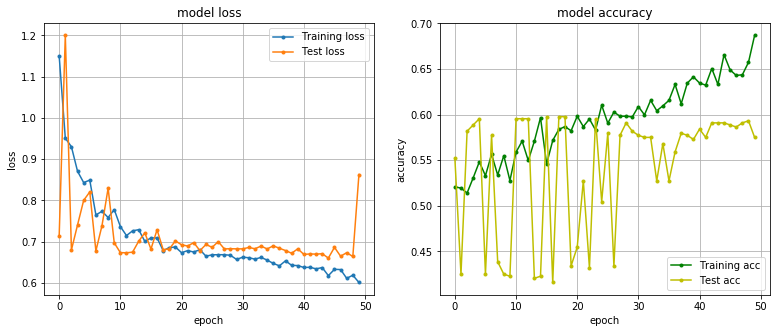

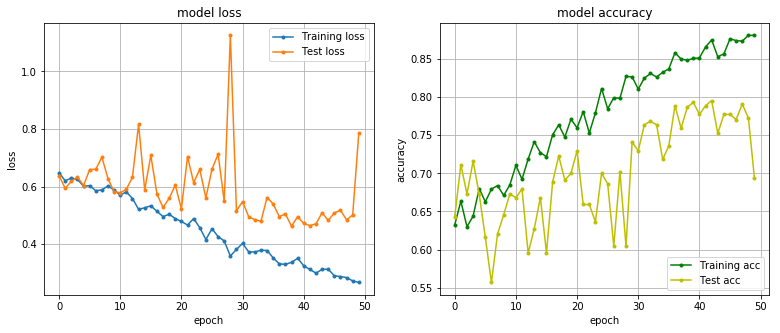

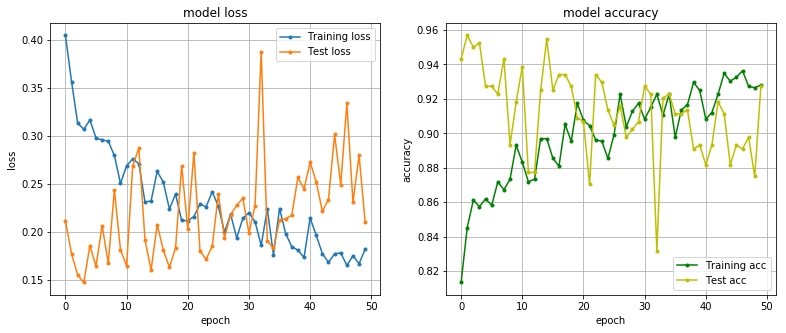

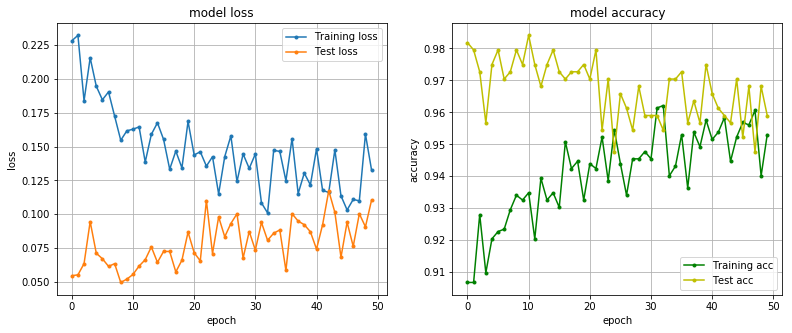

In [14]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4,shuffle=True)
kf.get_n_splits(X)
val_l = []
val_a = []
i=0
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    i=i+1
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
#     tbCallBack = keras.callbacks.TensorBoard(log_dir='/home/usma/Documents/Graph_Research', histogram_freq=0, write_graph=True, write_images=True)
    history=model.fit(X_train, Y_train,epochs=50,batch_size=32,validation_data=(X_test, Y_test))
#     history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(i)
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
   
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [33]:
# serialize model to JSON
model_json = model.to_json()
modelFileName = "final_model"
with open(modelFileName + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(modelFileName + ".h5")
print("Saved model to disk")

Saved model to disk


In [15]:
json_file = open('final_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [29]:
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.median(np.array(val_a)))

Average Validation Loss:  0.42662943831898953
Average Validation Accuracy:  0.7590909085490487


In [16]:
from keras.models import model_from_json
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("final_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
loaded_model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])
cc=loaded_model.evaluate(data3,newlabel3)

198/198 [==============================] - 1s 7ms/step


In [22]:
print(cc)

[1.1962792644597062, 0.5454545454545454]


Train on 1319 samples, validate on 440 samples
Epoch 1/60
1319/1319 [==============================] - 17s 13ms/step - loss: 1.0581 - acc: 0.4898 - val_loss: 1.3448 - val_acc: 0.4466
Epoch 2/60
1319/1319 [==============================] - 16s 12ms/step - loss: 0.9373 - acc: 0.5163 - val_loss: 0.7799 - val_acc: 0.5170
Epoch 3/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.8842 - acc: 0.5277 - val_loss: 0.9556 - val_acc: 0.5045
Epoch 4/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.8918 - acc: 0.5163 - val_loss: 0.9012 - val_acc: 0.4455
Epoch 5/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.8538 - acc: 0.5394 - val_loss: 0.9358 - val_acc: 0.4784
Epoch 6/60
1319/1319 [==============================] - 16s 12ms/step - loss: 0.8380 - acc: 0.5425 - val_loss: 0.8432 - val_acc: 0.4591
Epoch 7/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.8320 - acc: 0.5417 - val_loss: 0.8353 - val_acc: 0.4557
E

1319/1319 [==============================] - 15s 12ms/step - loss: 0.4658 - acc: 0.7847 - val_loss: 0.5699 - val_acc: 0.7102
Epoch 60/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.4412 - acc: 0.7885 - val_loss: 0.5747 - val_acc: 0.7091
Train on 1319 samples, validate on 440 samples
Epoch 1/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.5080 - acc: 0.7475 - val_loss: 0.3513 - val_acc: 0.9114
Epoch 2/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.4963 - acc: 0.7506 - val_loss: 0.3625 - val_acc: 0.9114
Epoch 3/60
1319/1319 [==============================] - 15s 11ms/step - loss: 0.5216 - acc: 0.7426 - val_loss: 0.3917 - val_acc: 0.8489
Epoch 4/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.4926 - acc: 0.7532 - val_loss: 0.3604 - val_acc: 0.8943
Epoch 5/60
1319/1319 [==============================] - 15s 12ms/step - loss: 0.4966 - acc: 0.7635 - val_loss: 0.3710 - val_acc: 0.8705
Epoch 6/60


1320/1320 [==============================] - 17s 13ms/step - loss: 0.2135 - acc: 0.9178 - val_loss: 0.6596 - val_acc: 0.8371
Epoch 58/60
1320/1320 [==============================] - 19s 14ms/step - loss: 0.2048 - acc: 0.9133 - val_loss: 0.4915 - val_acc: 0.8405
Epoch 59/60
1320/1320 [==============================] - 18s 14ms/step - loss: 0.2077 - acc: 0.9208 - val_loss: 0.3856 - val_acc: 0.8929
Epoch 60/60
1320/1320 [==============================] - 19s 14ms/step - loss: 0.1801 - acc: 0.9265 - val_loss: 0.4815 - val_acc: 0.8918
Validation Loss:  [0.7805425242944197, 0.591044388034127, 0.4170085316354578, 0.2404468378607939]  Validation accuracy:  [0.4840909080071883, 0.6818181818181818, 0.8170454545454545, 0.914578587970864]
Average Validation Loss:  0.5040264598347923
Average Validation Accuracy:  0.7243832830854222


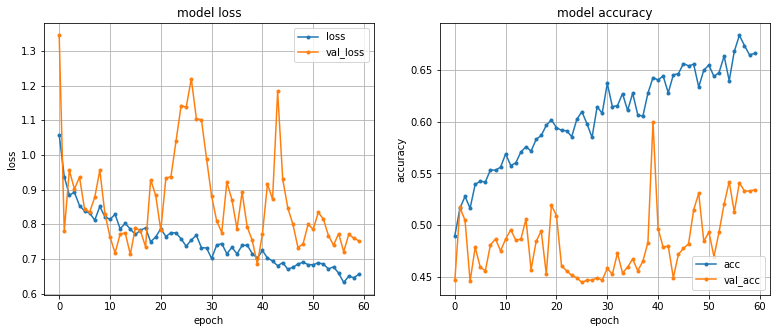

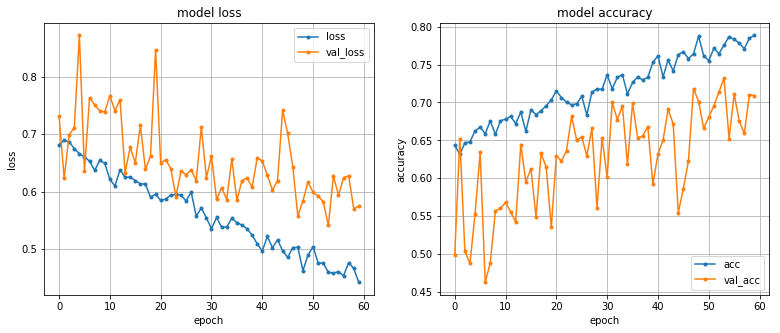

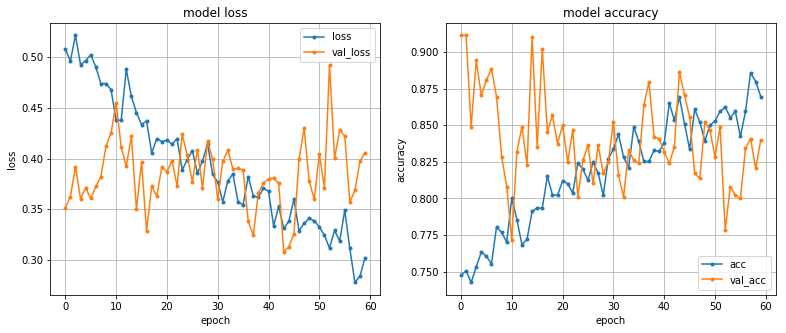

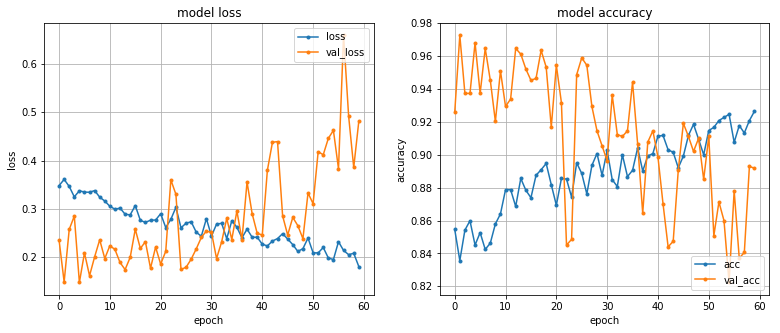

In [17]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4,shuffle=True)
kf.get_n_splits(X)
val_l = []
val_a = []
# 2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
#     tbCallBack = keras.callbacks.TensorBoard(log_dir='/home/usma/Documents/Graph', histogram_freq=0, write_graph=True, write_images=True)
    history=model.fit(X_train, Y_train,epochs=60,batch_size=32,validation_data=(X_test, Y_test))
#     history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot()
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
   
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [14]:
with open('cancer_detection_model_1.csv', 'w') as sf:
    sf.write('id,cancer\n')
    size = len(data3)
#     size = 3
    for i in range(size):
        a=loaded_model.predict(data3)[i]
        print(i)
        print(a)
        sf.write(newlabel3[i][:-4]+',')
        sf.write(str(a[0])+',') 
        sf.write(str(a[1])+'\n') 

0
[0.5367257  0.46327436]


TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

Train on 1319 samples, validate on 440 samples
Epoch 1/20
1319/1319 [==============================] - 17s 13ms/step - loss: 0.8602 - acc: 0.5171 - val_loss: 0.9033 - val_acc: 0.4773
Epoch 2/20
1319/1319 [==============================] - 15s 12ms/step - loss: 0.7932 - acc: 0.5315 - val_loss: 0.7064 - val_acc: 0.4955
Epoch 3/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.7773 - acc: 0.5644 - val_loss: 0.7371 - val_acc: 0.4852
Epoch 4/20
1319/1319 [==============================] - 15s 12ms/step - loss: 0.7614 - acc: 0.5622 - val_loss: 0.8562 - val_acc: 0.5886
Epoch 5/20
1319/1319 [==============================] - 15s 12ms/step - loss: 0.7532 - acc: 0.5747 - val_loss: 0.6871 - val_acc: 0.5818
Epoch 6/20
1319/1319 [==============================] - 15s 12ms/step - loss: 0.7537 - acc: 0.5682 - val_loss: 0.6676 - val_acc: 0.5864
Epoch 7/20
1319/1319 [==============================] - 15s 12ms/step - loss: 0.7231 - acc: 0.5898 - val_loss: 0.6982 - val_acc: 0.5250
E

Epoch 20/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.3153 - acc: 0.8704 - val_loss: 0.3961 - val_acc: 0.8500
Train on 1320 samples, validate on 439 samples
Epoch 1/20
1320/1320 [==============================] - 17s 13ms/step - loss: 0.3771 - acc: 0.8413 - val_loss: 0.2558 - val_acc: 0.8872
Epoch 2/20
1320/1320 [==============================] - 18s 14ms/step - loss: 0.3724 - acc: 0.8367 - val_loss: 0.3653 - val_acc: 0.7961
Epoch 3/20
1320/1320 [==============================] - 18s 14ms/step - loss: 0.3498 - acc: 0.8523 - val_loss: 0.2101 - val_acc: 0.9362
Epoch 4/20
1320/1320 [==============================] - 16s 12ms/step - loss: 0.3443 - acc: 0.8417 - val_loss: 0.2467 - val_acc: 0.9396
Epoch 5/20
1320/1320 [==============================] - 19s 14ms/step - loss: 0.3186 - acc: 0.8617 - val_loss: 0.2305 - val_acc: 0.9431
Epoch 6/20
1320/1320 [==============================] - 16s 12ms/step - loss: 0.2984 - acc: 0.8784 - val_loss: 0.1991 - val_acc: 0.9328


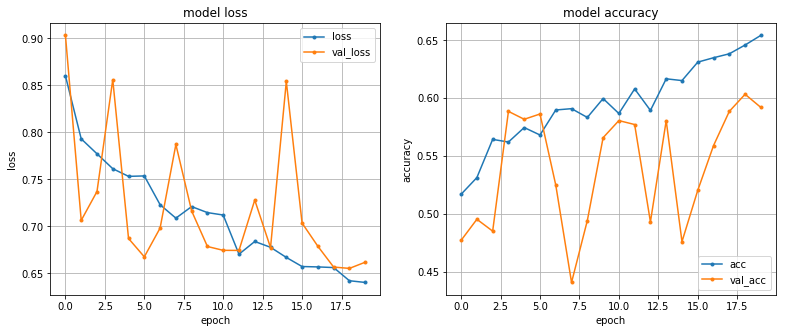

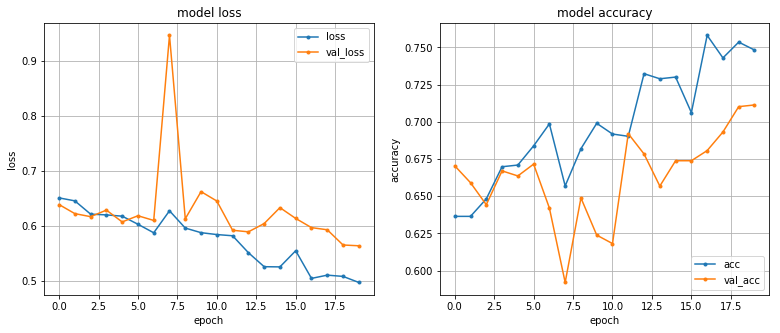

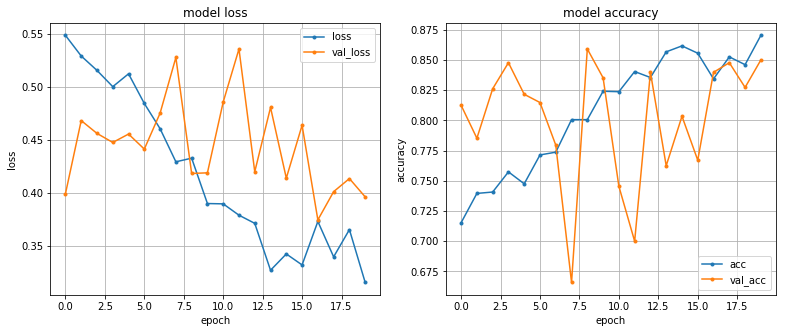

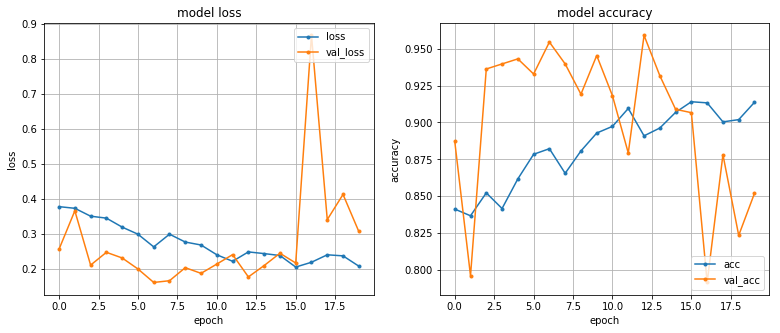

In [23]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4,shuffle=True)    #######lr=1e-3
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
#     tbCallBack = keras.callbacks.TensorBoard(log_dir='/home/usma/Documents/Graph', histogram_freq=0, write_graph=True, write_images=True)
    history=model.fit(X_train, Y_train,epochs=20,batch_size=32,validation_data=(X_test, Y_test))
#     history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot()
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
   
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [24]:
hist = model.evaluate(data3,newlabel3)

198/198 [==============================] - 1s 4ms/step


In [19]:
hist  ### lr = 1e-4

[1.0411359601550632, 0.5378787878787878]

In [25]:
hist

[1.1422585273029828, 0.5353535356545689]

Train on 1407 samples, validate on 352 samples
Epoch 1/100
1407/1407 [==============================] - 17s 12ms/step - loss: 0.9630 - acc: 0.5160 - val_loss: 0.9767 - val_acc: 0.4119
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.8951 - acc: 0.5096 - val_loss: 1.4642 - val_acc: 0.4162
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.8721 - acc: 0.5231 - val_loss: 1.2154 - val_acc: 0.4119
Epoch 4/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.8374 - acc: 0.5206 - val_loss: 1.3433 - val_acc: 0.4119
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.8468 - acc: 0.5110 - val_loss: 1.1648 - val_acc: 0.4247
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.8452 - acc: 0.5291 - val_loss: 1.2406 - val_acc: 0.4162
Epoch 7/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.8172 - acc: 0.5362 - val_loss: 1.3620 - val_acc: 0

1407/1407 [==============================] - 16s 11ms/step - loss: 0.5995 - acc: 0.7026 - val_loss: 0.9814 - val_acc: 0.4375
Epoch 61/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5763 - acc: 0.7200 - val_loss: 0.7696 - val_acc: 0.4716
Epoch 62/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5691 - acc: 0.7082 - val_loss: 0.7684 - val_acc: 0.4886
Epoch 63/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6027 - acc: 0.6951 - val_loss: 1.0138 - val_acc: 0.4403
Epoch 64/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5713 - acc: 0.7267 - val_loss: 0.9771 - val_acc: 0.4347
Epoch 65/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5812 - acc: 0.7143 - val_loss: 0.7963 - val_acc: 0.4815
Epoch 66/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5618 - acc: 0.7196 - val_loss: 0.7951 - val_acc: 0.4943
Epoch 67/100
1407/1407 [=======================

1407/1407 [==============================] - 16s 11ms/step - loss: 0.2517 - acc: 0.8948 - val_loss: 0.6299 - val_acc: 0.7088
Epoch 79/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.2266 - acc: 0.9101 - val_loss: 0.6443 - val_acc: 0.7244
Epoch 80/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.2258 - acc: 0.9083 - val_loss: 0.6718 - val_acc: 0.7116
Epoch 81/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.2238 - acc: 0.9080 - val_loss: 0.7028 - val_acc: 0.7017
Epoch 82/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.2366 - acc: 0.9033 - val_loss: 0.6320 - val_acc: 0.7457
Epoch 83/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.2344 - acc: 0.9030 - val_loss: 0.6684 - val_acc: 0.7528
Epoch 84/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.2200 - acc: 0.9151 - val_loss: 0.6636 - val_acc: 0.7330
Epoch 85/100
1407/1407 [=======================

1407/1407 [==============================] - 16s 11ms/step - loss: 0.1004 - acc: 0.9648 - val_loss: 1.1331 - val_acc: 0.8125
Epoch 97/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.1150 - acc: 0.9577 - val_loss: 1.3572 - val_acc: 0.7812
Epoch 98/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.1071 - acc: 0.9588 - val_loss: 1.8856 - val_acc: 0.7060
Epoch 99/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.1013 - acc: 0.9620 - val_loss: 1.5819 - val_acc: 0.7500
Epoch 100/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.1084 - acc: 0.9627 - val_loss: 1.6791 - val_acc: 0.7287
Train on 1407 samples, validate on 352 samples
Epoch 1/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.2209 - acc: 0.9136 - val_loss: 0.5500 - val_acc: 0.9134
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 0.2037 - acc: 0.9172 - val_loss: 1.0469 - val_acc: 0.8366
E

1408/1408 [==============================] - 16s 11ms/step - loss: 0.0766 - acc: 0.9723 - val_loss: 3.7274 - val_acc: 0.6895
Epoch 15/100
1408/1408 [==============================] - 16s 11ms/step - loss: 0.0917 - acc: 0.9659 - val_loss: 4.3201 - val_acc: 0.6766
Epoch 16/100
1408/1408 [==============================] - 16s 11ms/step - loss: 0.0840 - acc: 0.9673 - val_loss: 4.5928 - val_acc: 0.6738
Epoch 17/100
1408/1408 [==============================] - 16s 11ms/step - loss: 0.0868 - acc: 0.9688 - val_loss: 3.8705 - val_acc: 0.6952
Epoch 18/100
1408/1408 [==============================] - 16s 11ms/step - loss: 0.0996 - acc: 0.9645 - val_loss: 3.5233 - val_acc: 0.7037
Epoch 19/100
1408/1408 [==============================] - 16s 11ms/step - loss: 0.0889 - acc: 0.9659 - val_loss: 2.4303 - val_acc: 0.7678
Epoch 20/100
1408/1408 [==============================] - 16s 11ms/step - loss: 0.0757 - acc: 0.9719 - val_loss: 2.7486 - val_acc: 0.7365
Epoch 21/100
1408/1408 [=======================

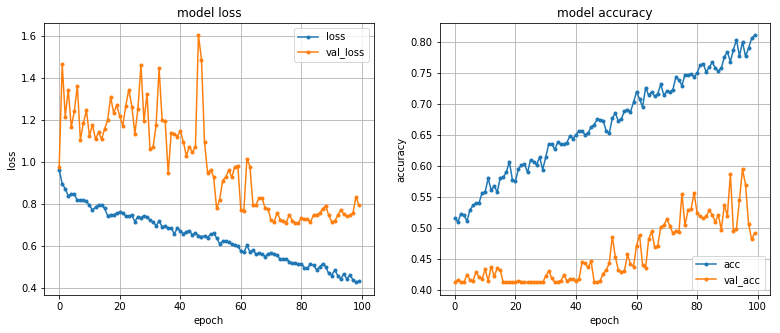

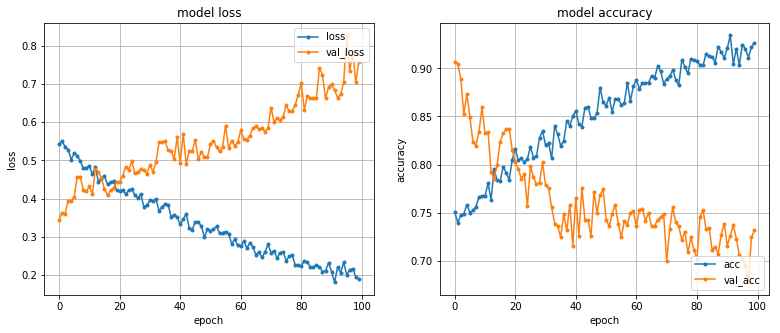

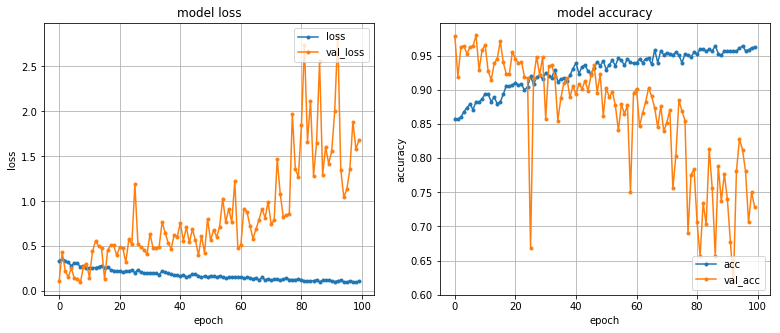

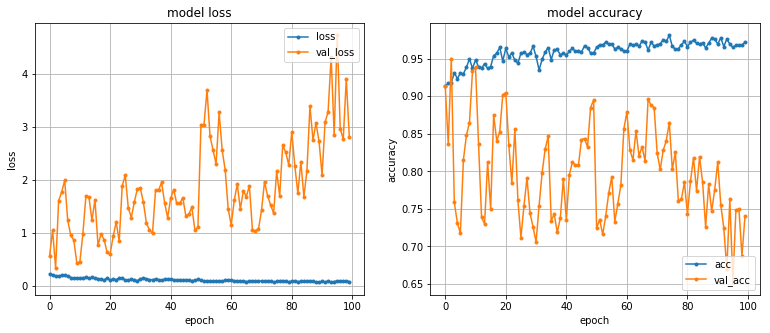

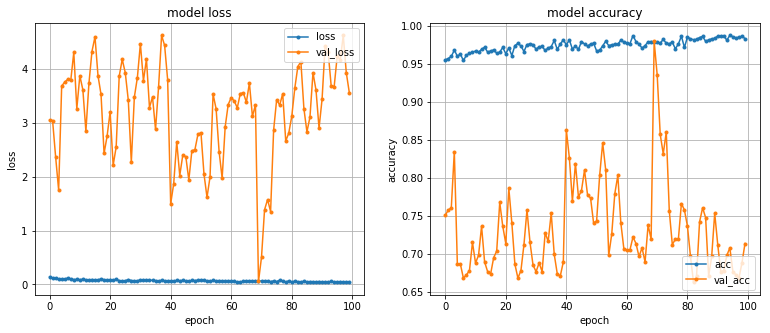

In [38]:
X = data1
Y = newlabel1
kf = KFold(n_splits=5)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
#     tbCallBack = keras.callbacks.TensorBoard(log_dir='/home/usma/Documents/Graph', histogram_freq=0, write_graph=True, write_images=True)
    history=model.fit(X_train, Y_train,epochs=100,batch_size=32,validation_data=(X_test, Y_test))
#     history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot()
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
   
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [16]:
import tensorflow as tf

In [31]:
import sklearn
sklearn.__version__




'0.19.1'

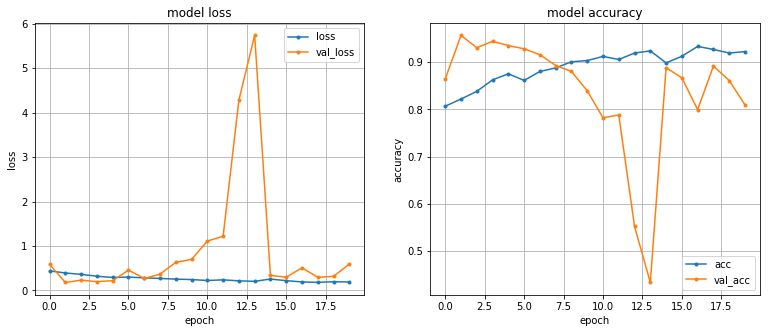

In [15]:
plot()

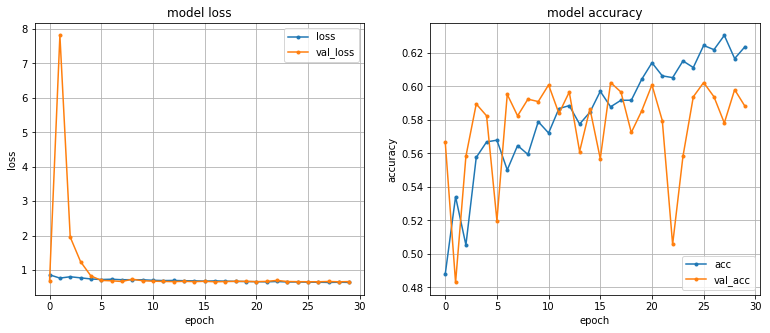

In [37]:
 model.layers[3].name
plot()

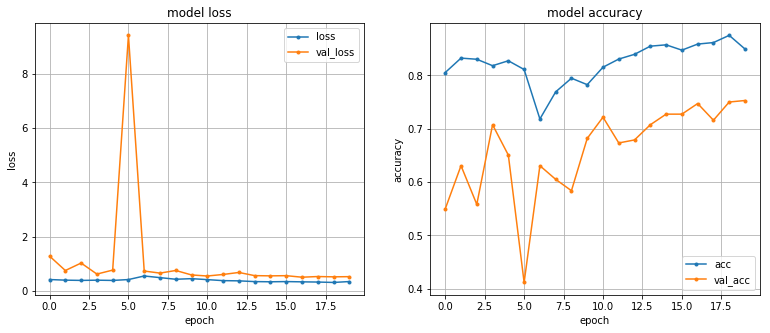

In [23]:
plot()

In [31]:
val_l=[]
val_a=[]
bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     plot(bbb)
val_l.append(history.history['val_loss'][bbb])
val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

Validation Loss:  [0.6718525615605441]  Validation accuracy:  [0.5880681818181818]
Average Validation Loss:  0.6718525615605441
Average Validation Accuracy:  0.5880681818181818


In [39]:
 model.layers[4].name

'conv3d_5'

## Filters

In [40]:
from keras.models import Model

# model = ...  # create the original model

layer_name = model.layers[4].name
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_test)

In [42]:
print(intermediate_output.shape)

(198, 64, 10, 25, 25)


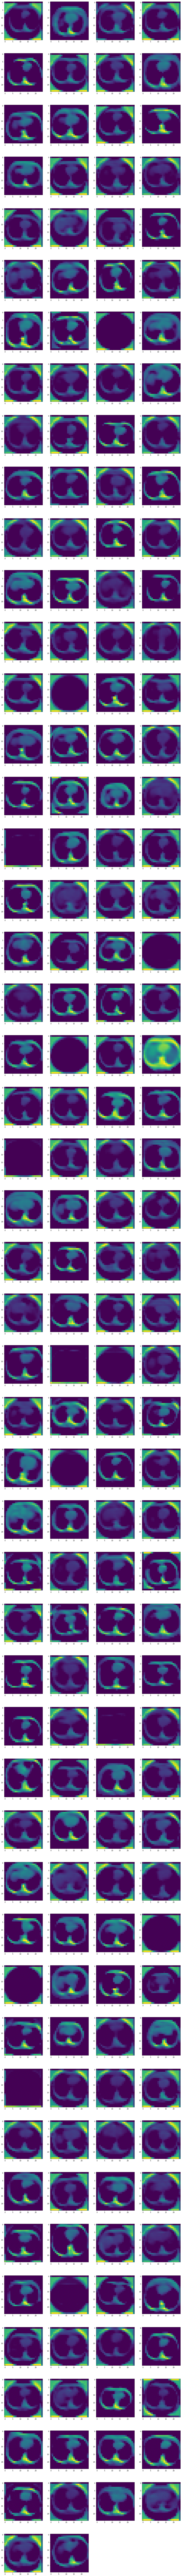

In [43]:
plt.figure(figsize=(20,300))
columns = 4
for i, image in enumerate(intermediate_output):
#     print(image.shape)
    plt.subplot(len(intermediate_output) / columns + 1, columns, i + 1)
#     image = (image[0] - image[0].min()) / (image[0].max() - image[0].min())
#     image[image>1] = 1.
#     image[image<0] = 0.

    plt.imshow(image[0][3])

In [34]:
filters1=model.layers[0].get_weights()
# filters2=model.layers[4].get_weights()
print(model.layers[0].name)
# print(model.layers[4].name)
print((filters1[0].shape))
# print((filters2[0].shape))

conv3d_4
(3, 3, 3, 1, 32)


In [35]:
img1 = filters1[0].reshape([32,1,3,3,3])
# img2 = filters2[0].reshape([64,32,3,3,3])

In [36]:
print(len(img1))
# print(len(img2))

32


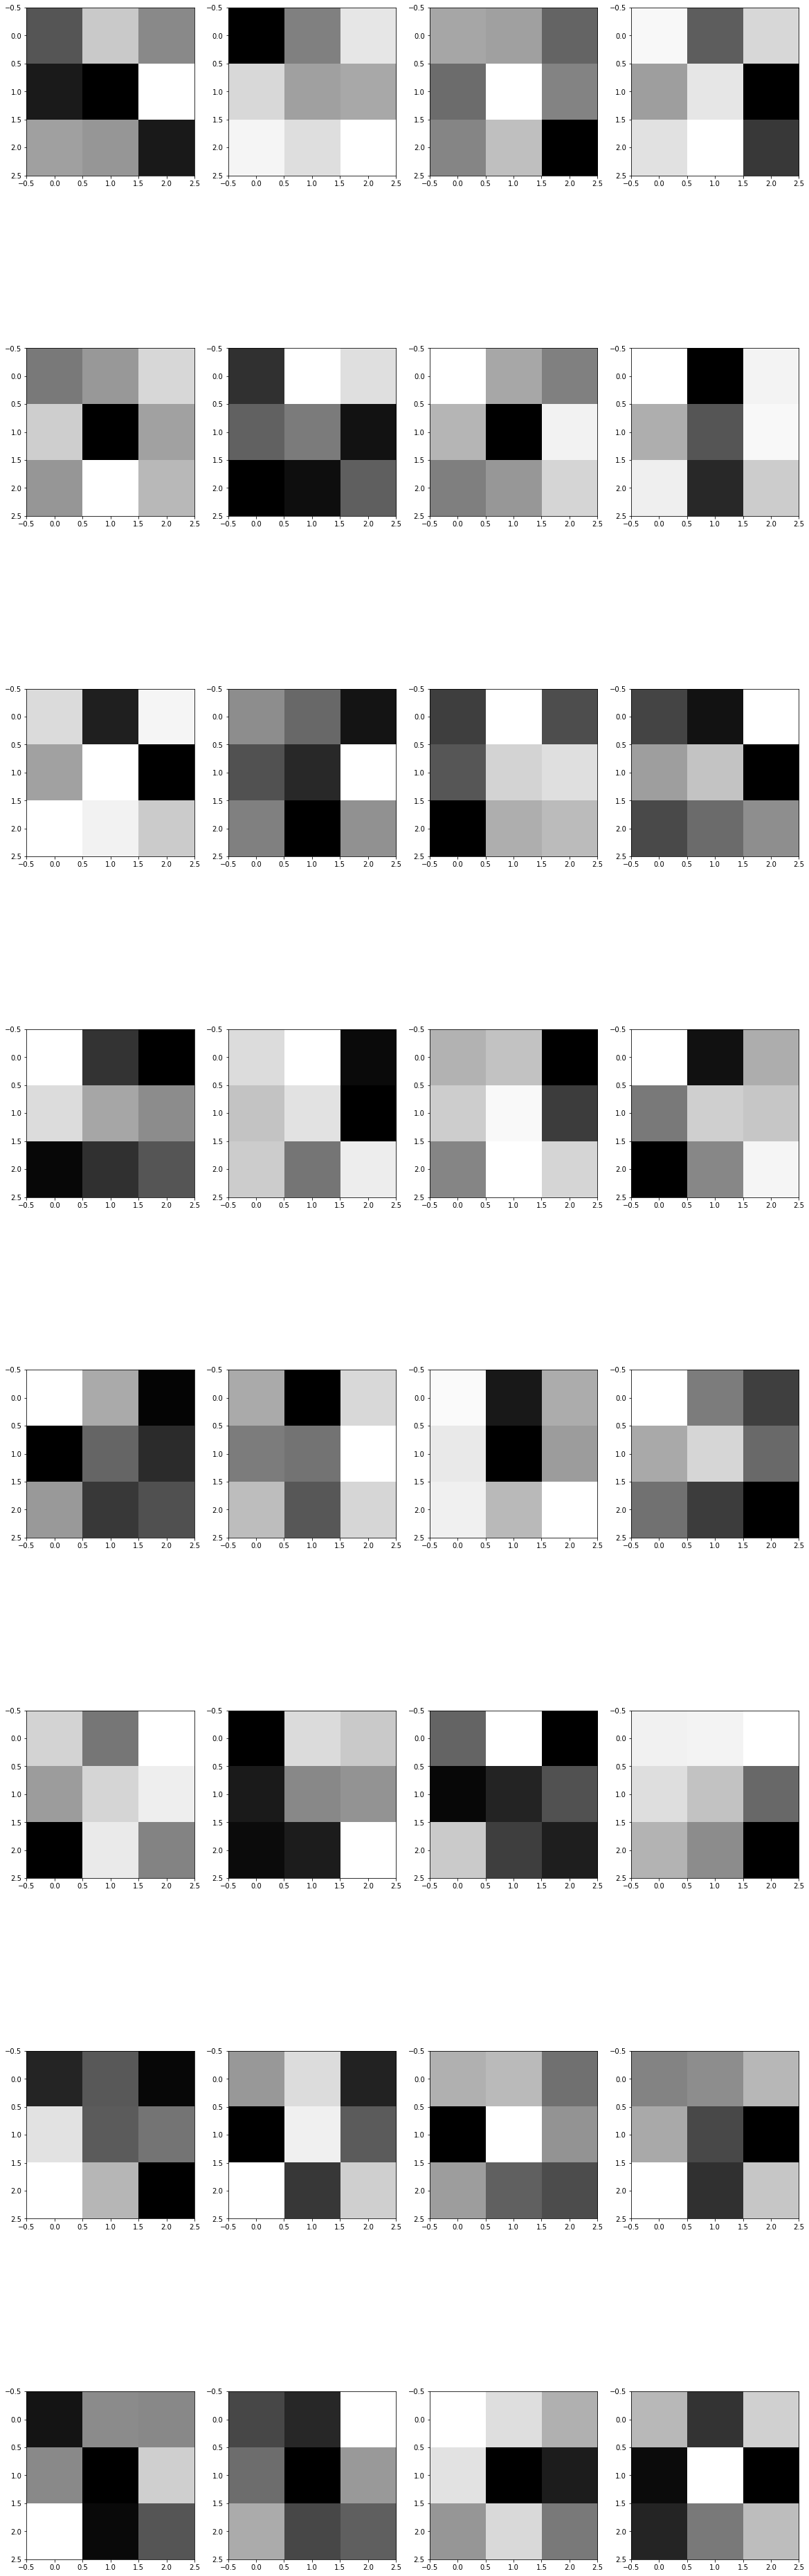

In [37]:
plt.figure(figsize=(20,80))
columns = 4
for i, image in enumerate(img1):
#     print(image.shape)
    plt.subplot(len(img1) / columns + 1, columns, i + 1)
#     image = (image[0] - image[0].min()) / (image[0].max() - image[0].min())
#     image[image>1] = 1.
#     image[image<0] = 0.

    plt.imshow(image[0][:,:,0],cmap='gray')
#     tt=image[0]*255
#     print(image.max())

## K FOLD FOR KAGGLE LUNG SEGMENT WITH NORMALIZATION

Train on 1319 samples, validate on 440 samples
Epoch 1/15
1319/1319 [==============================] - 16s 12ms/step - loss: 0.7360 - acc: 0.5842 - val_loss: 0.7040 - val_acc: 0.5250
Epoch 2/15
1319/1319 [==============================] - 15s 12ms/step - loss: 0.7018 - acc: 0.6008 - val_loss: 0.6996 - val_acc: 0.5409
Epoch 3/15
1319/1319 [==============================] - 15s 12ms/step - loss: 0.7010 - acc: 0.6077 - val_loss: 0.7990 - val_acc: 0.4352
Epoch 4/15
1319/1319 [==============================] - 15s 11ms/step - loss: 0.6845 - acc: 0.6209 - val_loss: 0.7045 - val_acc: 0.5398
Epoch 5/15
1319/1319 [==============================] - 15s 11ms/step - loss: 0.6896 - acc: 0.6187 - val_loss: 9.6490 - val_acc: 0.3864
Epoch 6/15
1319/1319 [==============================] - 15s 12ms/step - loss: 0.6980 - acc: 0.6012 - val_loss: 7.9417 - val_acc: 0.4977
Epoch 7/15
1319/1319 [==============================] - 15s 12ms/step - loss: 0.6840 - acc: 0.5989 - val_loss: 0.8275 - val_acc: 0.4682
E

Epoch 15/15
1320/1320 [==============================] - 15s 12ms/step - loss: 0.3086 - acc: 0.8568 - val_loss: 0.6413 - val_acc: 0.6822
Validation Loss:  [0.6995566227219322, 0.62745050950483838, 0.56455161138014365, 0.44561126692419989]  Validation accuracy:  [0.54090909199281167, 0.63409090963276948, 0.67386363744735722, 0.7767653743607037]
Average Validation Loss:  0.584292502633
Average Validation Accuracy:  0.656407253358


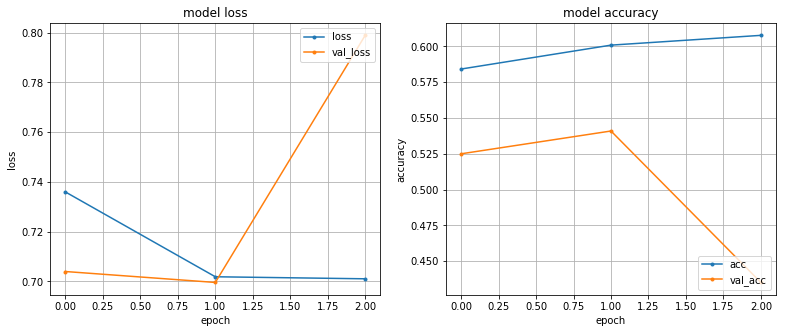

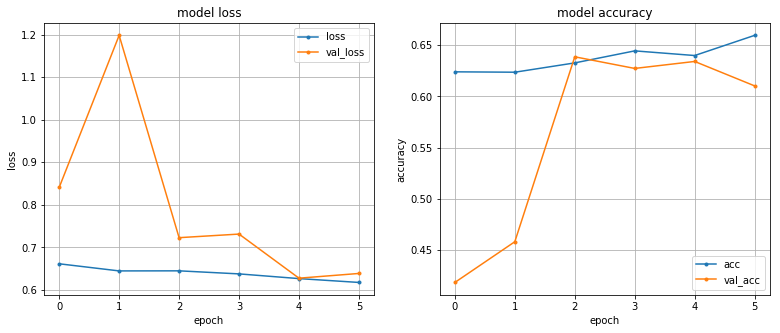

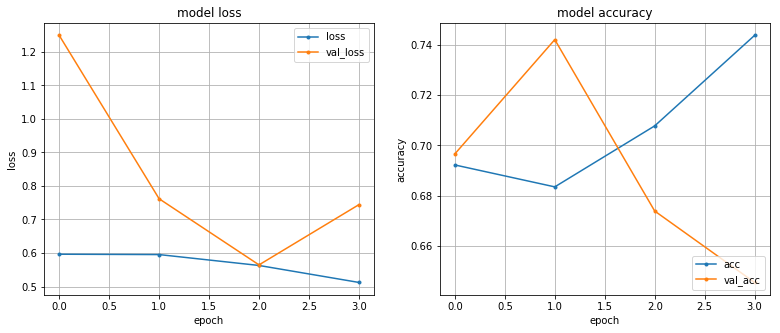

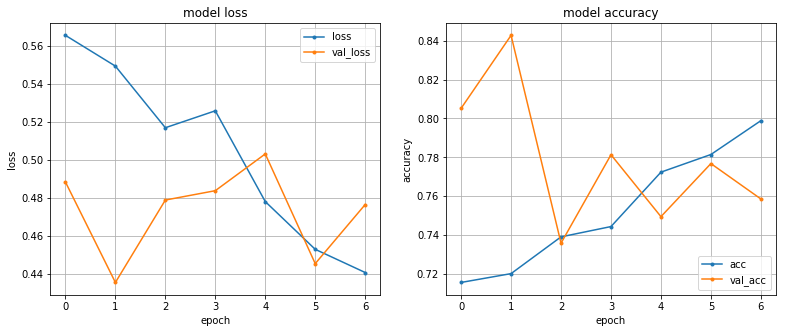

In [17]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [ ]:
del data1
del newlabel1
del data2
del newlabel2
del data3
del newlabel3
gc.collect()

In [29]:
loss,acc=model.evaluate(X_T,Y_T)

198/198 [==============================] - 1s 4ms/step


In [1]:
print(loss,acc)
# print(a?cc)
loss = 0.97
acc = 0.50

NameError: name 'loss' is not defined

## KFOLD FOR KAGGLE AND NSCLC LUNG SEGMENT WITH NORMALIZATION

Train on 1632 samples, validate on 545 samples
Epoch 1/15
1632/1632 [==============================] - 14s 8ms/step - loss: 0.6886 - acc: 0.5748 - val_loss: 0.9066 - val_acc: 0.1431
Epoch 2/15
1632/1632 [==============================] - 14s 9ms/step - loss: 0.6818 - acc: 0.5919 - val_loss: 0.9708 - val_acc: 0.1761
Epoch 3/15
1632/1632 [==============================] - 14s 8ms/step - loss: 0.6765 - acc: 0.5852 - val_loss: 0.8256 - val_acc: 0.2294
Epoch 4/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.6601 - acc: 0.6158 - val_loss: 0.7434 - val_acc: 0.3688
Epoch 5/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.6840 - acc: 0.5772 - val_loss: 0.7605 - val_acc: 0.3798
Epoch 6/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.6954 - acc: 0.5619 - val_loss: 0.5287 - val_acc: 0.8936
Epoch 7/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.6733 - acc: 0.5956 - val_loss: 0.6809 - val_acc: 0.6367
Epoch 8/

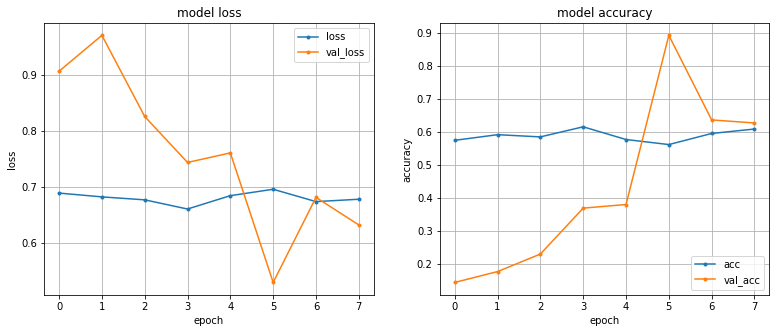

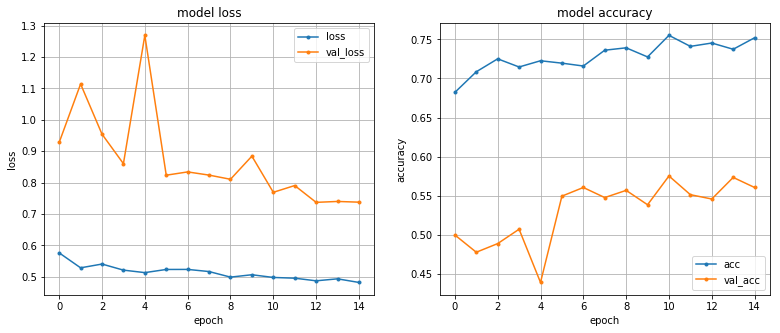

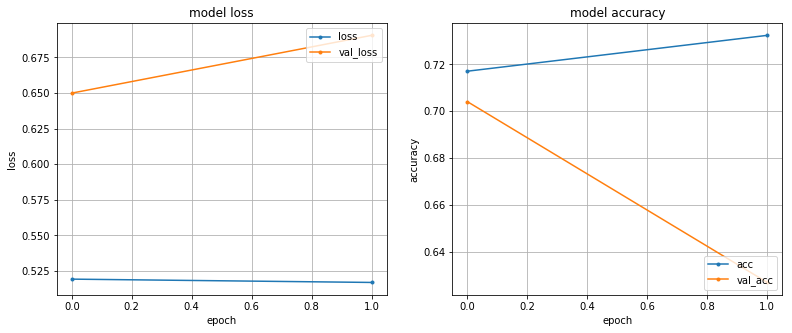

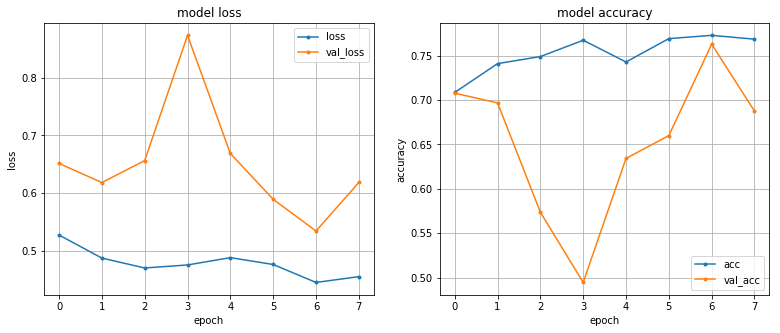

In [91]:
X = data2
Y = newlabel2
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [92]:
loss,acc=model.evaluate(X_T,Y_T);
print(loss)
print(acc)

198/198 [==============================] - 1s 3ms/step
0.983237096758
0.383838384139


## KFOLD FOR KAGGLE LUNG SEGMENT WITHOUT NORMALIZATION

Train on 1172 samples, validate on 587 samples
Epoch 1/20
1172/1172 [==============================] - 16s 14ms/step - loss: 0.9701 - acc: 0.5077 - val_loss: 2.0213 - val_acc: 0.4080
Epoch 2/20
1172/1172 [==============================] - 15s 13ms/step - loss: 0.8327 - acc: 0.5328 - val_loss: 1.3357 - val_acc: 0.4037
Epoch 3/20
1172/1172 [==============================] - 15s 13ms/step - loss: 0.7798 - acc: 0.5610 - val_loss: 1.3466 - val_acc: 0.3884
Epoch 4/20
1172/1172 [==============================] - 15s 13ms/step - loss: 0.7336 - acc: 0.5909 - val_loss: 1.1253 - val_acc: 0.3927
Epoch 5/20
1172/1172 [==============================] - 15s 13ms/step - loss: 0.7526 - acc: 0.5759 - val_loss: 0.9560 - val_acc: 0.4055
Epoch 6/20
1172/1172 [==============================] - 15s 13ms/step - loss: 0.7510 - acc: 0.5832 - val_loss: 0.8417 - val_acc: 0.4463
Epoch 7/20
1172/1172 [==============================] - 15s 13ms/step - loss: 0.7268 - acc: 0.5917 - val_loss: 0.9294 - val_acc: 0.4080
E

Epoch 20/20
1173/1173 [==============================] - 15s 13ms/step - loss: 0.2478 - acc: 0.9024 - val_loss: 0.7171 - val_acc: 0.6476
Validation Loss:  [0.84174804772794554, 0.61956211385466542, 0.52618381828578253]  Validation accuracy:  [0.44633730829675927, 0.64334470989761094, 0.72696245774474155]
Average Validation Loss:  0.619562113855
Average Validation Accuracy:  0.643344709898


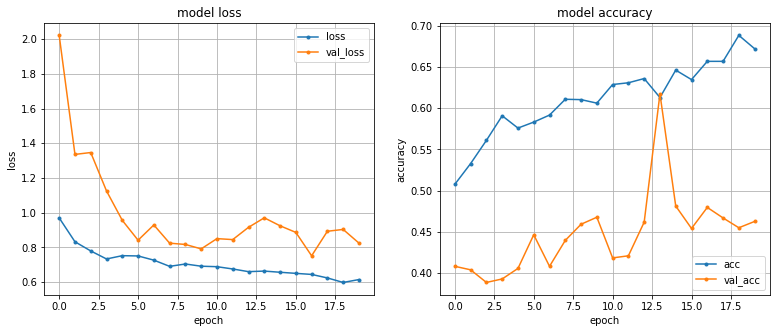

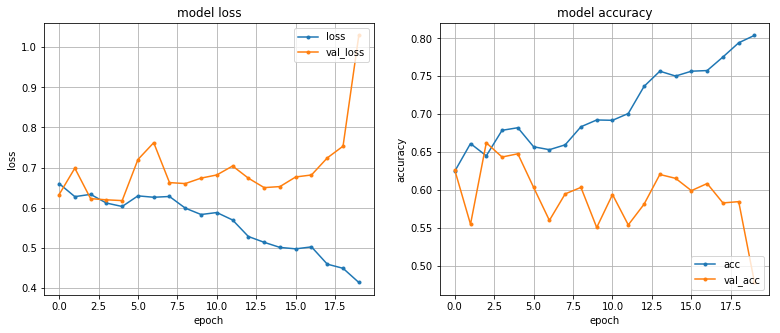

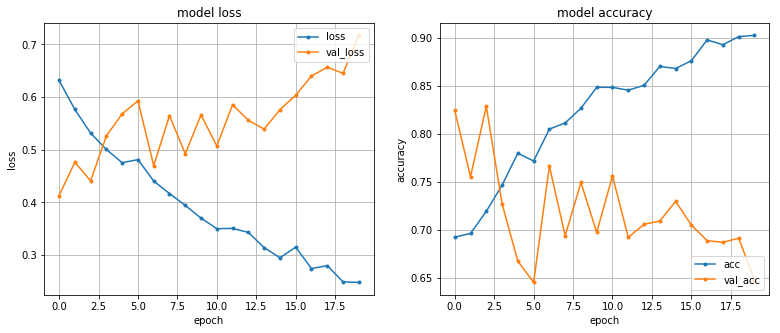

In [23]:
X = data1
Y = newlabel1
kf = KFold(n_splits=3)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=20,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot()
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.median(np.array(val_a)))

In [21]:
del model

In [18]:
loss,acc=model.evaluate(X_H,Y_H);
print(loss)
print(acc)

198/198 [==============================] - 1s 4ms/step
0.916069184289
0.606060606061


## KFOLD FOR KAGGLE AND NSCLC LUNG SEGMENT WITHOUT NORMALIZATION

Train on 1319 samples, validate on 440 samples
Epoch 1/30
1319/1319 [==============================] - 18s 14ms/step - loss: 0.9312 - acc: 0.5061 - val_loss: 1.2766 - val_acc: 0.4057
Epoch 2/30
1319/1319 [==============================] - 16s 12ms/step - loss: 0.8449 - acc: 0.5315 - val_loss: 0.9987 - val_acc: 0.3989
Epoch 3/30
1319/1319 [==============================] - 16s 12ms/step - loss: 0.8100 - acc: 0.5489 - val_loss: 0.8938 - val_acc: 0.4125
Epoch 4/30
1319/1319 [==============================] - 16s 12ms/step - loss: 0.8120 - acc: 0.5402 - val_loss: 0.6924 - val_acc: 0.5580
Epoch 5/30
1319/1319 [==============================] - 16s 12ms/step - loss: 0.7802 - acc: 0.5716 - val_loss: 0.8700 - val_acc: 0.4614
Epoch 6/30
1319/1319 [==============================] - 16s 12ms/step - loss: 0.7764 - acc: 0.5663 - val_loss: 0.7562 - val_acc: 0.4898
Epoch 7/30
1319/1319 [==============================] - 16s 12ms/step - loss: 0.7647 - acc: 0.5838 - val_loss: 0.9062 - val_acc: 0.4670
E

1320/1320 [==============================] - 17s 13ms/step - loss: 0.1877 - acc: 0.9303 - val_loss: 2.3679 - val_acc: 0.5057
Epoch 30/30
1320/1320 [==============================] - 16s 12ms/step - loss: 0.1851 - acc: 0.9303 - val_loss: 1.1221 - val_acc: 0.7574
Validation Loss:  [0.75620057907971472, 0.61313362229954116, 0.41413727619431234, 0.30487489204743456]  Validation accuracy:  [0.48977272727272725, 0.68409090909090908, 0.81363636472008449, 0.89863325794628379]
Average Validation Loss:  0.522086592405
Average Validation Accuracy:  0.721533314758


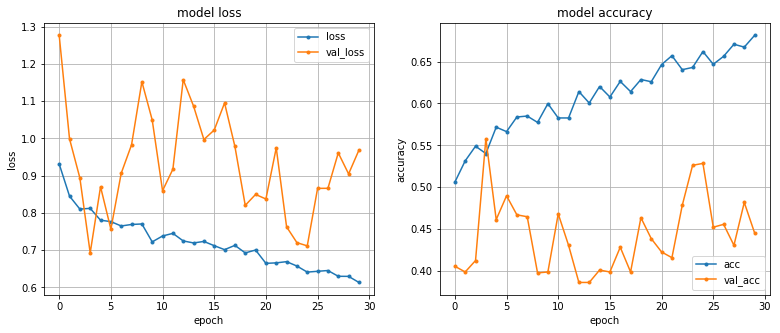

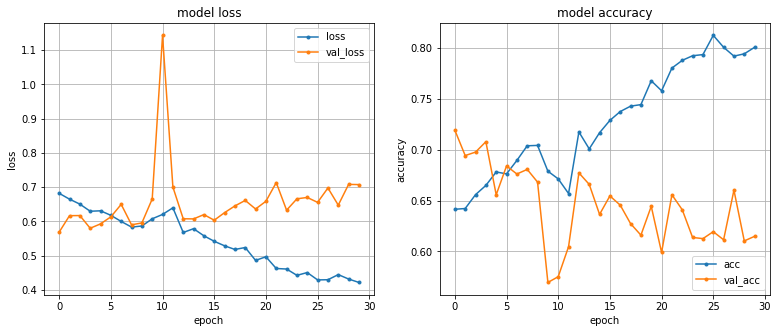

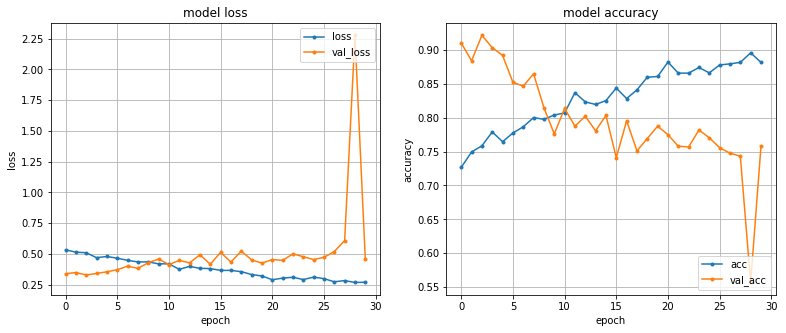

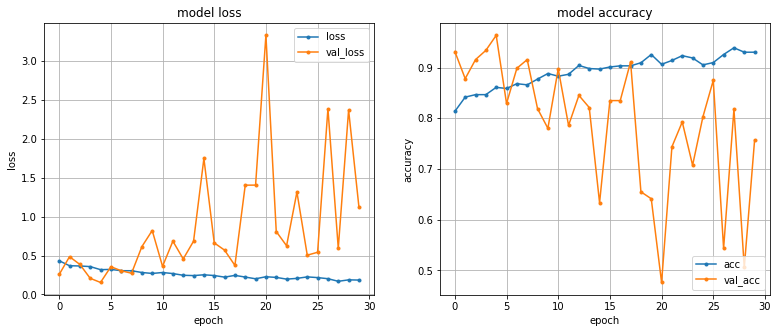

In [16]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=30,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot()
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.median(np.array(val_l)))
print("Average Validation Accuracy: ", np.median(np.array(val_a)))

In [21]:
loss,acc=model.evaluate(X_H,Y_H);print(loss,acc)

198/198 [==============================] - 1s 4ms/step
0.96319835776 0.595959596562


# MODEL 2

In [22]:
model = Sequential()
model.add(BatchNormalization(input_shape=[1,40,50,50]))
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))

model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))#layer1
model.add(BatchNormalization(axis=1))
# model.add(Dropout(0.5))

model.add(Conv3D(64, kernel_size=(3, 3, 3),  padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same') )#layer2
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer3
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 

model.add(Conv3D(256, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer4
model.add(BatchNormalization(axis=1))

model.add(Dropout(0.5))    

model.add(Conv3D(512, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer5
model.add(BatchNormalization(axis=1))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=.001), metrics=['accuracy'])

##  K FOLD for KAGGLE LUNG SEGMENT WITH NORMALIZATION

Train on 1319 samples, validate on 440 samples
Epoch 1/15
1319/1319 [==============================] - 12s 9ms/step - loss: 1.2669 - acc: 0.5178 - val_loss: 2.4141 - val_acc: 0.4045
Epoch 2/15
1319/1319 [==============================] - 11s 8ms/step - loss: 1.1457 - acc: 0.5246 - val_loss: 1.0054 - val_acc: 0.5500
Epoch 3/15
1319/1319 [==============================] - 11s 8ms/step - loss: 1.0617 - acc: 0.5208 - val_loss: 1.0915 - val_acc: 0.4068
Epoch 4/15
1319/1319 [==============================] - 11s 8ms/step - loss: 0.9940 - acc: 0.5315 - val_loss: 1.7964 - val_acc: 0.4591
Epoch 5/15
1319/1319 [==============================] - 11s 8ms/step - loss: 1.0058 - acc: 0.5201 - val_loss: 0.8319 - val_acc: 0.4545
Epoch 6/15
1319/1319 [==============================] - 11s 8ms/step - loss: 0.8648 - acc: 0.5444 - val_loss: 0.8596 - val_acc: 0.5227
Epoch 7/15
1319/1319 [==============================] - 11s 8ms/step - loss: 0.8701 - acc: 0.5254 - val_loss: 0.6883 - val_acc: 0.5864
Epoch 8/

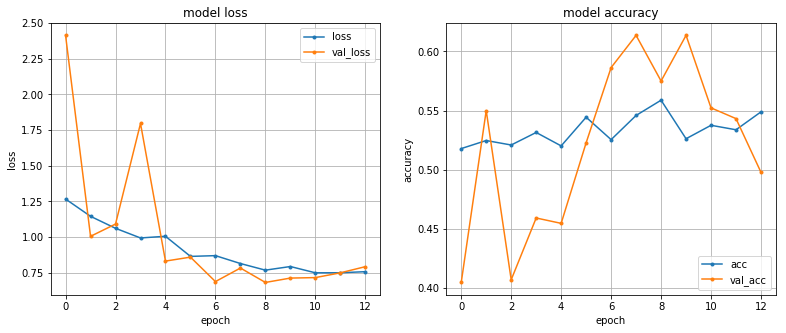

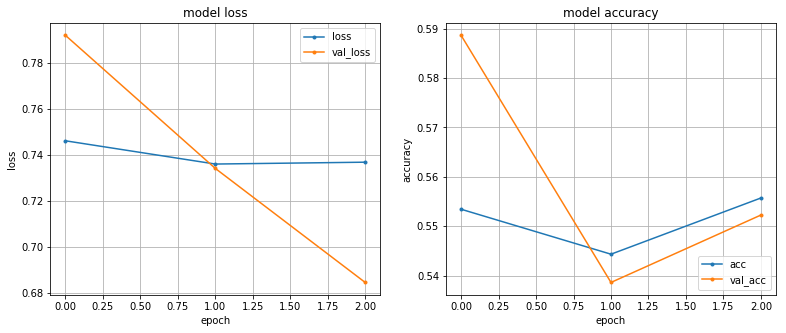

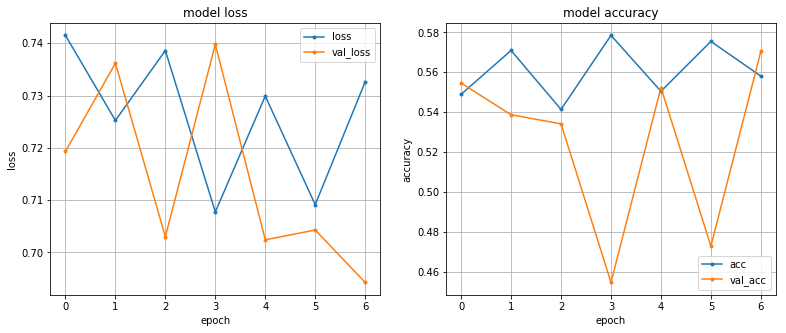

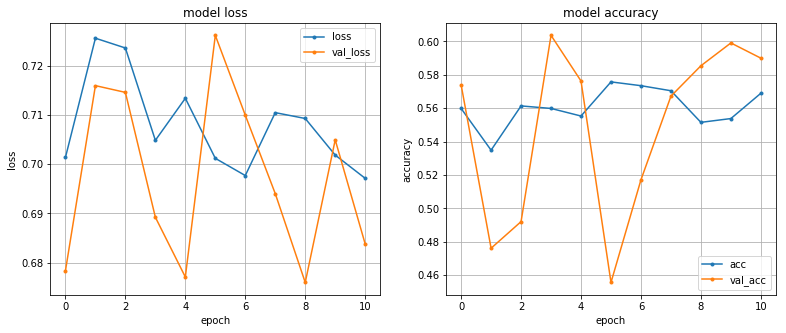

In [84]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [85]:
loss,acc=model.evaluate(X_T,Y_T)

198/198 [==============================] - 1s 3ms/step


In [86]:
print(loss,acc)

0.756230475325 0.358585858887


## K FOLD for KAGGLE and NSCLC LUNG SEGMENT WITH NORMALIZATION

Train on 1632 samples, validate on 545 samples
Epoch 1/15
1632/1632 [==============================] - 14s 8ms/step - loss: 1.1564 - acc: 0.5251 - val_loss: 0.3313 - val_acc: 0.8624
Epoch 2/15
1632/1632 [==============================] - 13s 8ms/step - loss: 1.0704 - acc: 0.5135 - val_loss: 0.5314 - val_acc: 0.7761
Epoch 3/15
1632/1632 [==============================] - 14s 8ms/step - loss: 0.9357 - acc: 0.5129 - val_loss: 0.8142 - val_acc: 0.5303
Epoch 4/15
1632/1632 [==============================] - 14s 8ms/step - loss: 0.8991 - acc: 0.5319 - val_loss: 1.5563 - val_acc: 0.1376
Epoch 5/15
1632/1632 [==============================] - 14s 8ms/step - loss: 0.8228 - acc: 0.5263 - val_loss: 0.8867 - val_acc: 0.4239
Epoch 6/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.7883 - acc: 0.5312 - val_loss: 0.6950 - val_acc: 0.5009
Epoch 7/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.7800 - acc: 0.5594 - val_loss: 1.1272 - val_acc: 0.1376
Epoch 8/

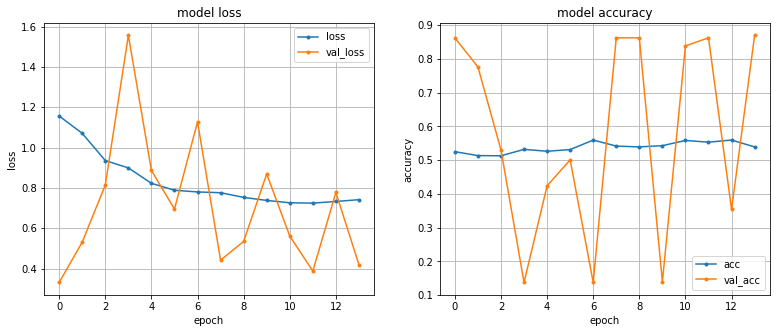

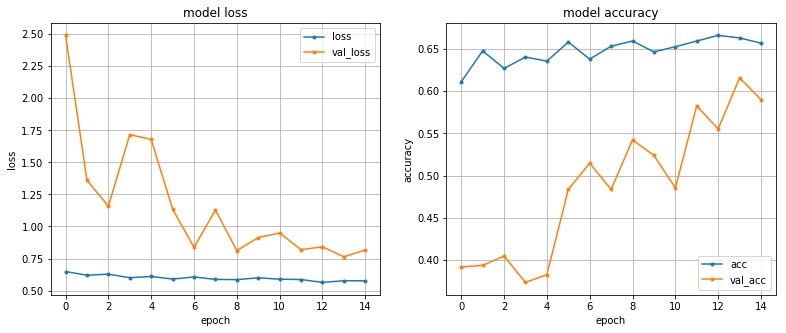

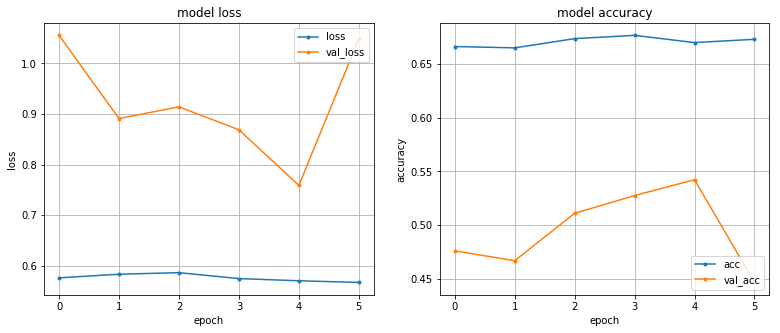

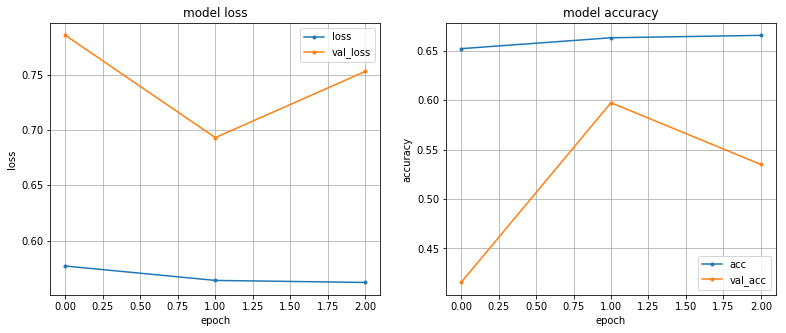

In [72]:
X = X
Y = Y
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [73]:
loss,acc=model.evaluate(X_T,Y_T)

198/198 [==============================] - 1s 3ms/step


In [74]:
print(loss)
print(acc)

0.930244421718
0.287878788029


## KFOLD FOR KAGGLE  LUNG SEGMENT WITHOUT NORMALIZATION

Train on 1319 samples, validate on 440 samples
Epoch 1/15
1319/1319 [==============================] - 18s 14ms/step - loss: 1.1992 - acc: 0.5216 - val_loss: 4.0438 - val_acc: 0.5864
Epoch 2/15
1319/1319 [==============================] - 11s 8ms/step - loss: 1.1103 - acc: 0.5224 - val_loss: 0.7775 - val_acc: 0.4727
Epoch 3/15
1319/1319 [==============================] - 11s 8ms/step - loss: 1.0904 - acc: 0.5224 - val_loss: 1.3487 - val_acc: 0.4295
Epoch 4/15
1319/1319 [==============================] - 11s 8ms/step - loss: 1.0455 - acc: 0.5125 - val_loss: 0.9666 - val_acc: 0.5750
Epoch 5/15
1319/1319 [==============================] - 11s 8ms/step - loss: 0.9492 - acc: 0.5368 - val_loss: 0.8531 - val_acc: 0.5864
Epoch 6/15
1319/1319 [==============================] - 11s 8ms/step - loss: 0.8821 - acc: 0.5489 - val_loss: 0.7476 - val_acc: 0.5273
Epoch 7/15
1319/1319 [==============================] - 11s 8ms/step - loss: 0.8561 - acc: 0.5519 - val_loss: 0.7124 - val_acc: 0.5455
Epoch 8

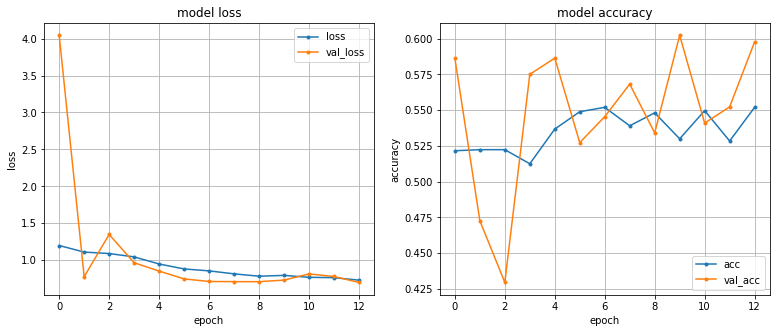

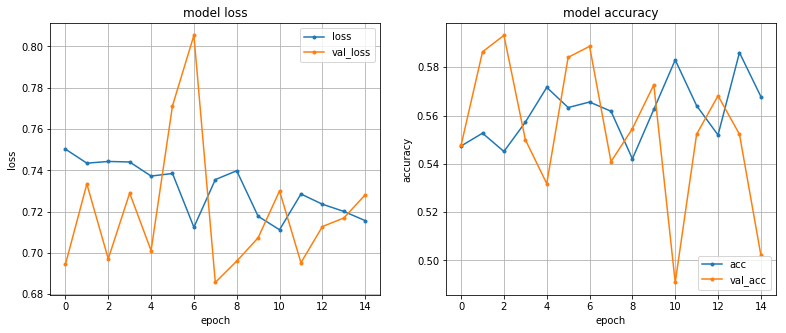

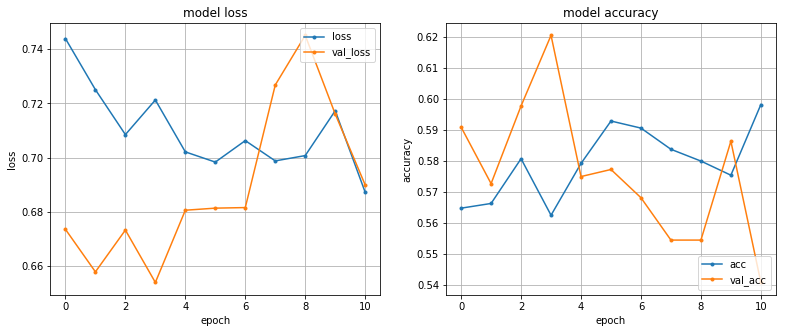

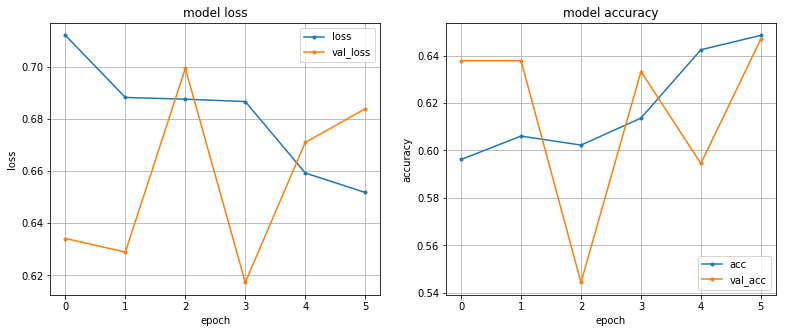

In [69]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [70]:
loss,acc=model.evaluate(X_H,Y_H);print(loss,acc)

198/198 [==============================] - 1s 3ms/step
4.64005776367 0.712121211519


## KFOLD FOR KAGGLE AND NSCLC LUNG SEGMENT WITHOUT NORMALIZATION

Train on 1632 samples, validate on 545 samples
Epoch 1/15
1632/1632 [==============================] - 14s 9ms/step - loss: 1.2411 - acc: 0.5251 - val_loss: 2.0823 - val_acc: 0.3835
Epoch 2/15
1632/1632 [==============================] - 13s 8ms/step - loss: 1.0576 - acc: 0.5208 - val_loss: 0.7434 - val_acc: 0.7046
Epoch 3/15
1632/1632 [==============================] - 13s 8ms/step - loss: 1.0838 - acc: 0.5202 - val_loss: 0.5849 - val_acc: 0.6771
Epoch 4/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.9382 - acc: 0.5331 - val_loss: 1.5128 - val_acc: 0.1450
Epoch 5/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.8902 - acc: 0.5349 - val_loss: 0.4053 - val_acc: 0.8679
Epoch 6/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.8487 - acc: 0.5545 - val_loss: 0.4207 - val_acc: 0.8550
Epoch 7/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.8235 - acc: 0.5429 - val_loss: 0.5466 - val_acc: 0.8165
Epoch 8/

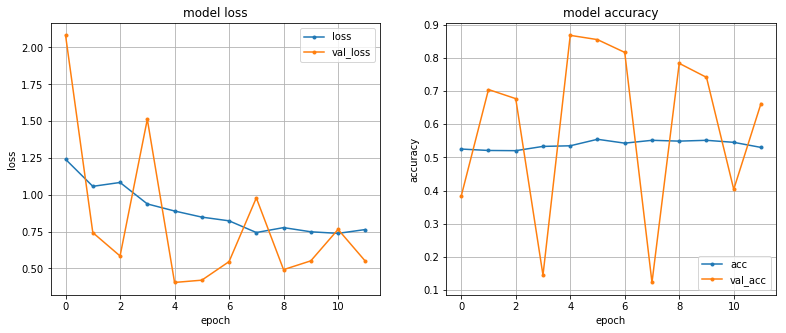

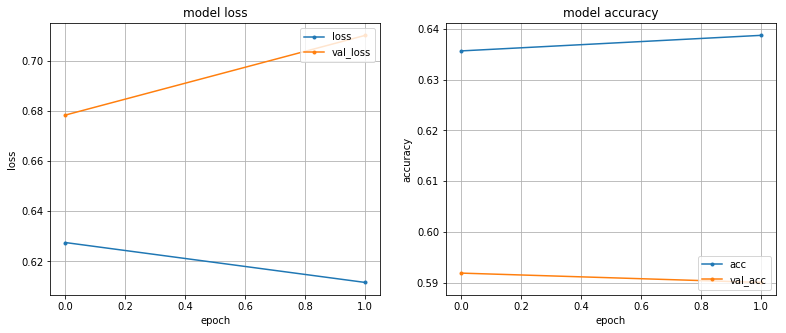

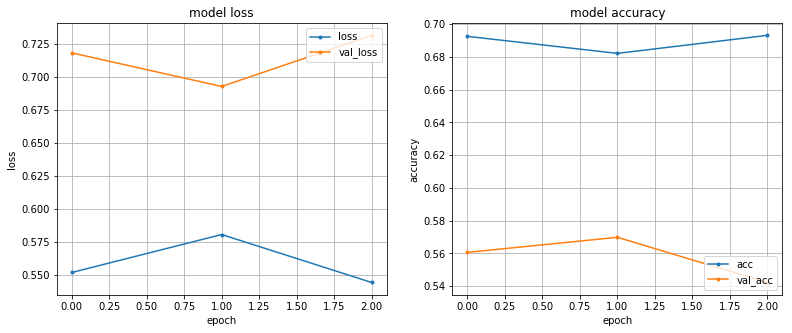

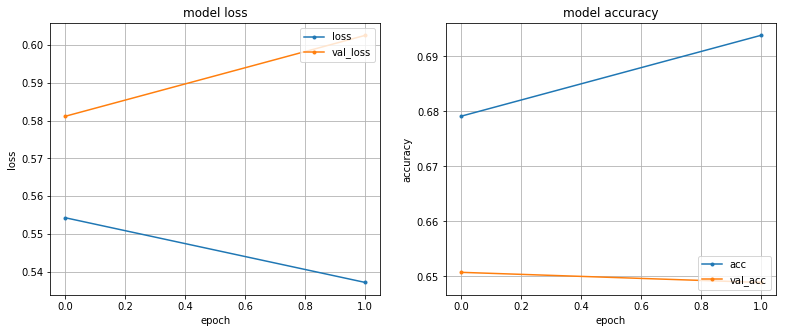

In [23]:
X = data2
Y = newlabel2
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [24]:
loss,acc=model.evaluate(X_H,Y_H);print(loss,acc)

198/198 [==============================] - 1s 3ms/step
0.694976172664 0.606060605459


In [25]:
# serialize model to JSON
model_json = model.to_json()
modelFileName = "K_Fold_KBS_NSC_without_norm"
with open(modelFileName + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(modelFileName + ".h5")
print("Saved model to disk")

Saved model to disk
